Оригинал:<br>
https://github.com/anishathalye/neural-style

In [1]:
import tensorflow as tf
import numpy as np
import scipy.io
import scipy.misc as misc
import os
import math
from sys import stderr
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
from io import BytesIO
import matplotlib.pyplot as plt

In [2]:
def vgg_net(data_path, input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )

    data = scipy.io.loadmat(data_path)
    mean = data['normalization'][0][0][0]
    mean_pixel = np.mean(mean, axis=(0, 1))
    weights = data['layers'][0]

    net = {}
    current = input_image
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = _pool_layer(current)
        net[name] = current

    assert len(net) == len(layers)
    return net, mean_pixel


def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)


def _pool_layer(input):
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')


def preprocess(image, mean_pixel):
    return image - mean_pixel


def unprocess(image, mean_pixel):
    return image + mean_pixel

In [50]:
CONTENT_LAYER = 'relu4_2'
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')


try:
    reduce
except NameError:
    from functools import reduce


def stylize(network, initial, content, styles, iterations,
        content_weight, style_weight, style_blend_weights, tv_weight,
        learning_rate, print_iterations=None, checkpoint_iterations=None):
    """
    Stylize images.
    This function yields tuples (iteration, image); `iteration` is None
    if this is the final image (the last iteration).  Other tuples are yielded
    every `checkpoint_iterations` iterations.
    :rtype: iterator[tuple[int|None,image]]
    """
    shape = (1,) + content.shape
    style_shapes = [(1,) + style.shape for style in styles]
    content_features = {}
    style_features = [{} for _ in styles]

    # compute content features in feedforward mode
    g = tf.Graph()
    with g.as_default(), g.device('/gpu:0'), tf.Session() as sess:
        image = tf.placeholder('float', shape=shape)
        net, mean_pixel = vgg_net(network, image)
        content_pre = np.array([preprocess(content, mean_pixel)])
        content_features[CONTENT_LAYER] = net[CONTENT_LAYER].eval(
                feed_dict={image: content_pre})

    # compute style features in feedforward mode
    for i in range(len(styles)):
        g = tf.Graph()
        with g.as_default(), g.device('/gpu:0'), tf.Session() as sess:
            image = tf.placeholder('float', shape=style_shapes[i])
            net, _ = vgg_net(network, image)
            style_pre = np.array([preprocess(styles[i], mean_pixel)])
            for layer in STYLE_LAYERS:
                features = net[layer].eval(feed_dict={image: style_pre})
                features = np.reshape(features, (-1, features.shape[3]))
                gram = np.matmul(features.T, features) / features.size
                style_features[i][layer] = gram

    # make stylized image using backpropogation
    with tf.Graph().as_default():
        if initial is None:
            noise = np.random.normal(size=shape, scale=np.std(content) * 0.1)
            initial = tf.random_normal(shape) * 0.256
        else:
            initial = np.array([preprocess(initial, mean_pixel)])
            initial = initial.astype('float32')
        image = tf.Variable(initial)
        net, _ = vgg_net(network, image)

        # content loss
        content_loss = content_weight * (2 * tf.nn.l2_loss(
                net[CONTENT_LAYER] - content_features[CONTENT_LAYER]) /
                content_features[CONTENT_LAYER].size)
        # style loss
        style_loss = 0
        for i in range(len(styles)):
            style_losses = []
            for style_layer in STYLE_LAYERS:
                layer = net[style_layer]
                _, height, width, number = map(lambda i: i.value, layer.get_shape())
                size = height * width * number
                feats = tf.reshape(layer, (-1, number))
                gram = tf.matmul(tf.transpose(feats), feats) / size
                style_gram = style_features[i][style_layer]
                style_losses.append(2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size)
            style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)
        # total variation denoising
        tv_y_size = _tensor_size(image[:,1:,:,:])
        tv_x_size = _tensor_size(image[:,:,1:,:])
        tv_loss = tv_weight * 2 * (
                (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
                    tv_y_size) +
                (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
                    tv_x_size))
        # overall loss
        loss = content_loss + style_loss + tv_loss

        # optimizer setup
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        def print_progress(i, last=False):
            if i % 50 == 0:
                stderr.write('Iteration %d/%d\n' % (i + 1, iterations))
            if last or (print_iterations and i % print_iterations == 0):
                stderr.write('  content loss: %g\n' % content_loss.eval())
                stderr.write('    style loss: %g\n' % style_loss.eval())
                stderr.write('       tv loss: %g\n' % tv_loss.eval())
                stderr.write('    total loss: %g\n' % loss.eval())

        # optimization
        best_loss = float('inf')
        best = None
        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
            for i in range(iterations):
                last_step = (i == iterations - 1)
                print_progress(i, last=last_step)
                train_step.run()

                if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
                    this_loss = loss.eval()
                    if this_loss < best_loss:
                        best_loss = this_loss
                        best = image.eval()
                    yield (
                        (None if last_step else i),
                        unprocess(best.reshape(shape[1:]), mean_pixel)
                    )


def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

In [46]:
CONTENT_WEIGHT = 5e0
STYLE_WEIGHT = 1e2
TV_WEIGHT = 1e2
LEARNING_RATE = 1e1
STYLE_SCALE = 1.0
ITERATIONS = 500
VGG_PATH = './imagenet-vgg-verydeep-19.mat'

In [25]:
IMAGE_TO_PROCESS = "./images/pilatus800.jpg"
IMAGE_STYLES = ["./styles/starry_night.jpg"]
STYLE_BLEND_WEIGHTS = None #[1.0]

In [6]:
def imread(path):
    return misc.imread(path).astype(np.float)


def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    misc.imsave(path, img)

In [2]:
print "Images: \n"
for img in os.listdir('./images/'):
    print 'images/'+img
    
print '----------\nStyles: \n'
for img in os.listdir('./styles/'):
    print 'styles/'+img

Images: 

images/mailru.jpg
images/pilatus800.jpg
----------
Styles: 

styles/starry_night.jpg
styles/picasso.jpg


Instructions for updating:
Use `tf.global_variables_initializer` instead.


Iteration 1/500
Iteration 51/500
Iteration 101/500
Iteration 151/500
Iteration 201/500
Iteration 251/500
Iteration 301/500
Iteration 351/500
Iteration 401/500
Iteration 451/500
  content loss: 1.79723e+06
    style loss: 283329
       tv loss: 214831
    total loss: 2.29539e+06


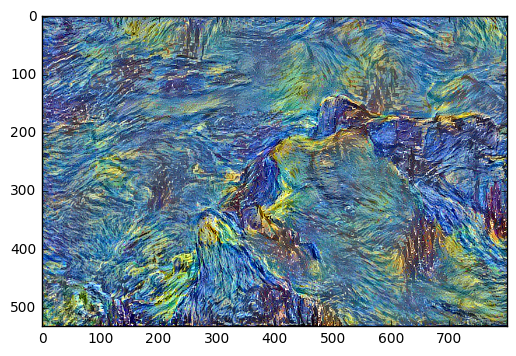

In [51]:
if not os.path.isfile(VGG_PATH):
    print "Network does not exist. (Did you forget to download it?)"

content_image = imread(IMAGE_TO_PROCESS)
style_images = [imread(style) for style in IMAGE_STYLES]

# width = options.width
# if width is not None:
#     new_shape = (int(math.floor(float(content_image.shape[0]) /
#             content_image.shape[1] * width)), width)
#     content_image = scipy.misc.imresize(content_image, new_shape)
target_shape = content_image.shape
for i in range(len(style_images)):
    style_scale = STYLE_SCALE
#     if options.style_scales is not None:
#         style_scale = options.style_scales[i]
#     style_images[i] = scipy.misc.imresize(style_images[i], style_scale *
#             target_shape[1] / style_images[i].shape[1])

style_blend_weights = STYLE_BLEND_WEIGHTS
if STYLE_BLEND_WEIGHTS is None:
    # default is equal weights
    style_blend_weights = [1.0/len(style_images) for _ in style_images]
else:
    total_blend_weight = sum(style_blend_weights)
    style_blend_weights = [weight/total_blend_weight
                           for weight in style_blend_weights]

# initial = options.initial
# if initial is not None:
#     initial = scipy.misc.imresize(imread(initial), content_image.shape[:2])

# if options.checkpoint_output and "%s" not in options.checkpoint_output:
#     parser.error("To save intermediate images, the checkpoint output "
#                  "parameter must contain `%s` (e.g. `foo%s.jpg`)")

for iteration, image in stylize(
    network=VGG_PATH,
    initial=None,
    content=content_image,
    styles=style_images,
    iterations=ITERATIONS,
    content_weight=CONTENT_WEIGHT,
    style_weight=STYLE_WEIGHT,
    style_blend_weights=style_blend_weights,
    tv_weight=TV_WEIGHT,
    learning_rate=LEARNING_RATE,
    print_iterations=None,
    checkpoint_iterations=None
):
#     output_file = None
#     if iteration is not None:
#         if options.checkpoint_output:
#             output_file = options.checkpoint_output % iteration
#     else:
#         output_file = options.output
#     if output_file:
#         imsave(output_file, image)
    if iteration is None:
        plt.imshow(np.clip(image, 0, 255).astype(np.uint8))
        plt.show()